# Large-scale Distributed $k$-means Algorithm

In this Notebook, we'll focus on the development of a simple distributed algorithm. As for the Notebook on SGD, we focus on iterative algorithms, which eventually converge to a desired solution.

In what follows, we'll proceed with the following steps:

* We first introduce formally the $k$-means algorithm
* Then we focus on a serial implementation. To do this, we'll first generate some data using scikit. In passing, we'll also use the $k$-means implementation in scikit to have a baseline to compare against.
* Subsequently, we will focus on some important considerations and improvements to the serial implementation of $k$-means.
* At this point, we'll design our distributed version of the $k$-means algorithm using pyspark, and re-implement the enhancements we designed for the serial version 

#### References:
* https://en.wikipedia.org/wiki/K-means_clustering
* http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/kmeans.ipynb
* https://apache.googlesource.com/spark/+/master/examples/src/main/python/kmeans.py
* https://github.com/castanan/w2v/blob/master/ml-scripts/w2vAndKmeans.py


#### Preamble code

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs
import time
import collections

# Preliminaries: the $k$-means algorithm

$k$-means clustering aims to partition $n$ $d-$dimensional observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.
The problem is computationally difficult (NP-hard); however, there are efficient heuristic algorithms that are commonly employed and converge quickly to a local optimum. In this Notebook we'll focus on one of them in particular: the Lloyd algorithm.

The $k$-means problem can be formalized as follows. Given a set of observations $(x_1, x_2, \cdots, x_n)$, where each observation is a $d$-dimensional real vector, $k$-means clustering aims to partition the $n$ observations into $k \leq n$ sets $S = \{S_1, S_2, \cdots, S_k\}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). 
The objective is to find:

$$
\arg \min_S \sum_{i=1}^{k} \sum_{x \in S_i} || \boldsymbol{x} - \boldsymbol{\mu_i} ||^2
$$

The most common algorithm uses an iterative refinement technique. Given an initial set of $k$ centroids $\mu_1^{(1)}, \cdots, \mu_k^{(1)}$ , the algorithm proceeds by alternating between two steps: in the **assignment step**, observations are associated to the closest **centroid**, in terms of squared Euclidean distance; in the **update step** new centroids are computed based on the new points associated to each centroid. Note: $\mu_i^{(t)}$ stands for the $i$-th centroid as of the $t$-th iteration. So $\mu_1^{(1)}$ is the centroid 1 at iteration 1.

## Algorithm pseudo-code
It is important to work on a principled approach to the design of large-scale algorithms, and this starts with using good data structures and scientific libraries, such as ```numpy``` and ```scipy```. In particular, we will focus on the use of ```numpy``` arrays, which come with efficient methods for array operations. A pseudo-code for the $k$-means algorithm is specified below:

```python
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    centroids = X[rand_indices]
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance
        # assign each data point to the closest centroid
        cluster_assignment = # array Index = data point Index; array value = closest centroid Index
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = ...
        
        # STOP CONDITION
        # if centroids == new_centroids => stop
 
    
```

# Synthetic data generation: working in bi-dimensional spaces

Next, we use sklearn to generate some synthetic data to test our algorithm.

In [6]:
X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)

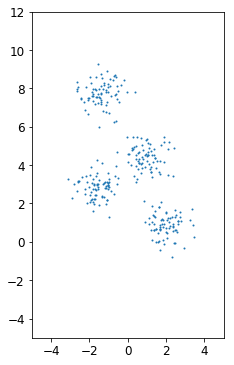

In [124]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# scatter plot
plt.scatter(X[:, 0], X[:, 1], s = 1)
plt.ylim(-5, 12)
plt.xlim(-5, 5)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of k-means, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform k-means clustering. The function should accept as inputs: the training data x, the number of clusters k, and the iteration budget you allocate to the algorithm. Additional arguments might include the use of a random seed to initialize centroids.</li>
    <li>The function should output the centroids, and the cluster assignment, that is, to which centroid each data point is assigned to</li>
    <li> Optionally, keep track of the position of the centroids, for each iteration.</li>
</ul>

<br>
Once the ```kmeans``` function is defined, you can generate input data according to the cell above, that uses scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> Print the number of data points that belong to each cluster</li>
    <li> Plot the clustered data points:</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

In [125]:
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """
    centroid_history = []
    
    if (seed != None):
        np.random.seed(seed)
    
    # randomly choose k data points as initial centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False), :]

    centroid_history.append(centroids)

    #Creating the distance matrix and the cluster assignment list
    distance_matrix = np.zeros((len(X) , k))
    cluster_assignment = np.zeros(len(X))

    
    for itr in range(maxiter):
       
        #Computing the distance matrix
        for i in range(len(X)):
            for j in range(k):
                distance_matrix[i][j] = np.linalg.norm(X[i]-centroids[j])

        #Assigning each point to a cluster ( in cluster assignment the index correspond to
        #the index of X and the value to the clusters assigned to it)
        for i in range(len(X)):
            cluster_assignment[i] = int(np.argmin(distance_matrix[i]))
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = []
        for j in range(k):
            list_index = np.argwhere(cluster_assignment==j)
            sum = 0
            for u in range(len(list_index)):
                sum += X[list_index[u][0]]
            centroid = sum/len(list_index)
            new_centroids.append(centroid)
        
        # STOP CONDITION
        if (np.array_equal(centroids,new_centroids)):
            break
            
        #NEW CENTROIDS ASSIGMENT 
        centroids = new_centroids 
        centroid_history.append(centroids)

        
    return np.array(centroids) , np.array(centroid_history) , cluster_assignment
 

Cluster repartition
Counter({3.0: 75, 1.0: 75, 2.0: 75, 0.0: 75})


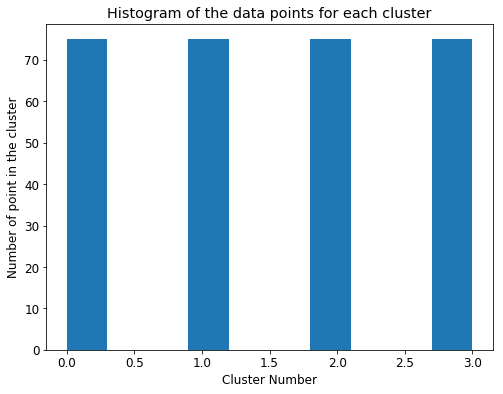

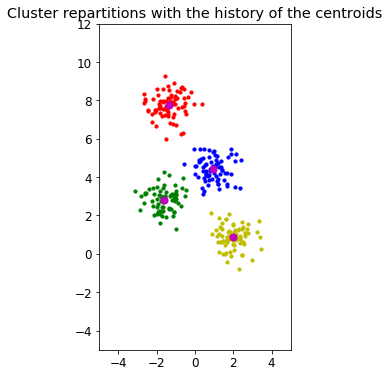

In [126]:
#### Testing our function ####
k = 4
centroids , centroid_history , cluster_assignment = kmeans(X, k, 100, None)

#Dictionnary with the cluster number and the number of point belonging to it
print('Cluster repartition')
print(collections.Counter(cluster_assignment))


#Plotting the histogram for each cluster 
plt.hist(cluster_assignment )
plt.title('Histogram of the data points for each cluster')
plt.xlabel('Cluster Number')
plt.ylabel ('Number of point in the cluster')
plt.figure()



#Color of the different clusters
color = ['g' , 'r' , 'b' , 'y'  ]

#Creating the list of datapoint associated to each cluster
for j in range(len(centroids)):
    #List of indexes of data belonging to cluster j
    list_index = np.argwhere(cluster_assignment==j)
    cluster = np.zeros((len(list_index),2))
    for p in range(len(list_index)):
        cluster[p] = X[list_index[p][0]]
    #Plotting the point with the color corresponding to their cluster
    plt.scatter(cluster[: , 0] , cluster[: , 1] , s=10, color = color[j])

    
#Plotting the centroid of each cluster
plt.scatter(centroids[: , 0] , centroids[: , 1] , s=50 , color = 'm' )    

  


plt.title('Cluster repartitions with the history of the centroids')
plt.ylim(-5, 12)
plt.xlim(-5, 5)
plt.gca().set_aspect('equal')
plt.show()
    


<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Use the built-in k-means implementation in sklearn and determine centroids and clusters.

Follow the guidelines below:

<ul>
    <li> Use the KMeans algorithm from sklearn</li>
    <li> Use the fit_predict method to cluster data</li>
    <li> Use the cluster_centers_ method to retrieve centroids</li>
</ul>

The output of your cell should contain the following information:
<ul>
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

Cluster repartition
Counter({0: 75, 2: 75, 1: 75, 3: 75})


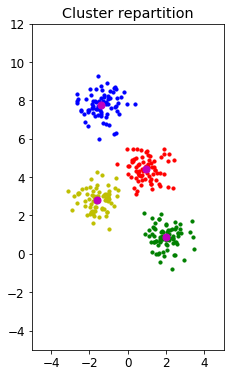

In [127]:
#KMEANs with sklearn
kmeans_sk = KMeans(n_clusters=k, random_state=0).fit(X)
clustering = kmeans_sk.predict(X)
centers = kmeans_sk.cluster_centers_

plt.figure()

#Color of the different clusters
color = ['g' , 'r' , 'b' , 'y'  ]


#Dictionnary with the cluster number and the number of point belonging to it
print('Cluster repartition')
print(collections.Counter(clustering))

#Plotting the different cluster
for j in range(k):
    list_index = np.argwhere(clustering==j)
    cluster = np.zeros((len(list_index),2))
    for p in range(len(list_index)):
        cluster[p] = X[list_index[p]]
    ##Plotting the point with the color corresponding to their cluster
    plt.scatter(cluster[: , 0] , cluster[: , 1] , s=10 , color = color[j])

#Plotting the centroids
plt.scatter(centers[: , 0] , centers[: , 1] , s=50 , color = 'm' )    

plt.title('Cluster repartition')
plt.ylim(-5, 12)
plt.xlim(-5, 5)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Use the sklearn dataset API to generate alternative synthetic data to test your k-means algorithm implementation.

Follow the guidelines from this document: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py


The output of your cell should contain the following information:
<ul>
    <li> Plot the new synthetic dataset you generated
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

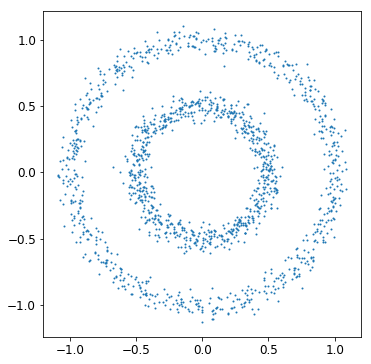

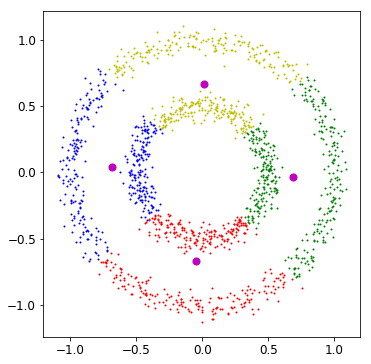

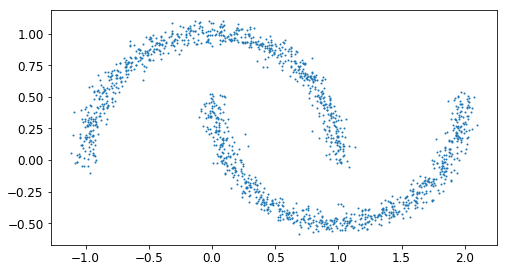

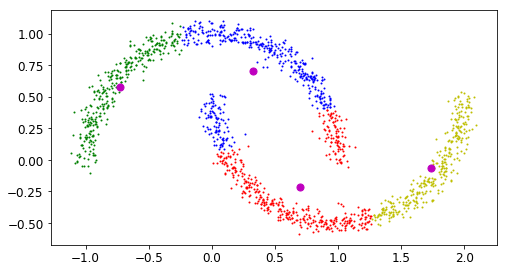

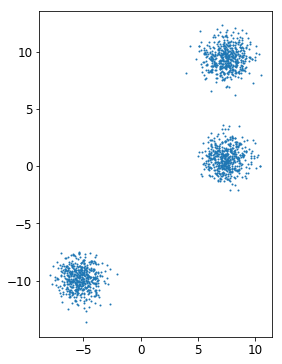

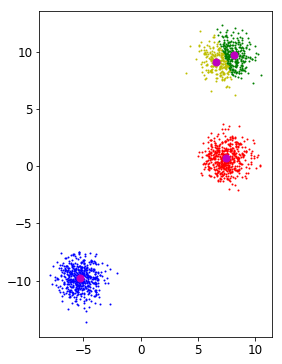

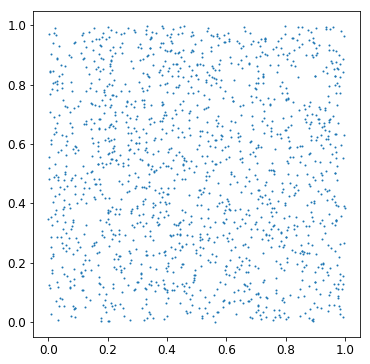

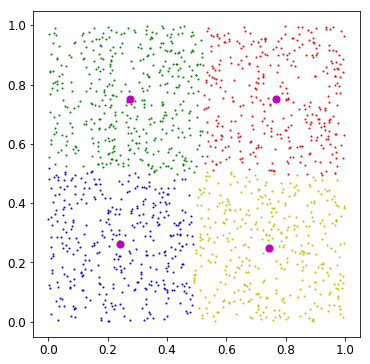

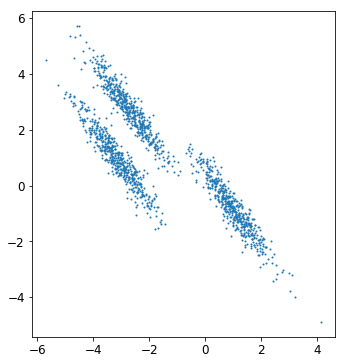

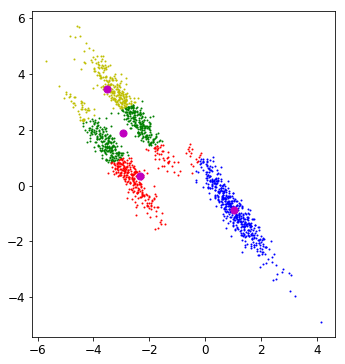

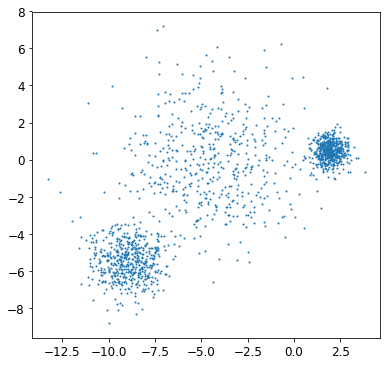

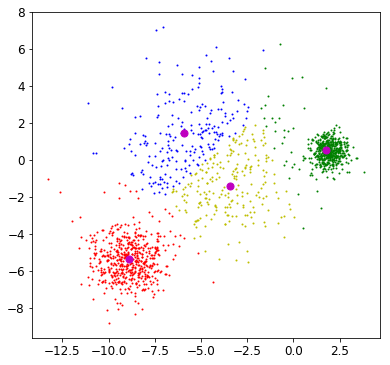

In [128]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


#Realising the different datasets with the skelarn dataset API
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X2, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X2, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

datasets = [noisy_circles , noisy_moons , blobs , no_structure , aniso , varied]


#Loop for to realise plot the datasets with and without kmenas
for dataset in datasets:
    
    plt.figure()
    plt.scatter(dataset[0][:, 0], dataset[0][:, 1], s = 1)
    #plt.ylim(-5, 12)
    #plt.xlim(-5, 5)
    plt.gca().set_aspect('equal')
    plt.show()
    
    # k we choose in this example
    k = 4

    centroids , centroid_history , cluster_assignment = kmeans(dataset[0], k, 100, None)

    plt.figure()

    #Color list of the cluster
    color = ['g' , 'r' , 'b' , 'y'  ]

    #Plotting the cluster and the data point
    for j in range(len(centroids)):
        list_index = np.argwhere(cluster_assignment==j)
        cluster = np.zeros((len(list_index),2))
        for p in range(len(list_index)):
            cluster[p] = dataset[0][list_index[p][0]]

        plt.scatter(cluster[: , 0] , cluster[: , 1] , s=1 , color = color[j])

    plt.scatter(centroids[: , 0] , centroids[: , 1] , s=50 , color = 'm' )    

    #plt.ylim(-5, 12)
    #plt.xlim(-5, 5)
    plt.gca().set_aspect('equal')
    plt.show()

    
    

***

# A simplified analysis of algorithm convergence

One well-known weakness of $k$-means is that the algorithm's performance is closely tied with the randomly generated initial centroids' quality. If the algorithm starts with a set of bad inital centers, it will get stuck in a local minimum.

Instead of taking a formal approach to study the convergence of $k$-means, let's study it with an experimental approach. One thing we can do is to build a measure of clustering quality: intuitively, a good clustering result should produce clusters in which data points should be very close to their centroids, and very far from other centroids. In this Notebook, we'll look at a metric called the **total within Sum of Squares**, which is sometimes referred ot as heterogeneity. Mathematically, we define heterogeneity as:

$$
\mathcal{H} = \sum_{j=1}^{k} \sum_{i: z_i=j} || \boldsymbol{x_i} - \boldsymbol{\mu_j}||_{2}^{2}
$$

Where $k$ denotes the total number of clusters, $x_i$ is the $i$-th data point, $\mu_j$ is the $j$-th centroid, and $|| \cdot ||_{2}^{2}$ denotes the squared L2 norm (Euclidean distance) between the two vectors.

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Modify your own version of k-means, to compute heterogeneity as defined above.

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [129]:
def kmeans_heterogeneity(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """
    centroid_history = []
    
    #If seed is none, the initialization is completely random
    if (seed != None):
        np.random.seed(seed)
    
    # randomly choose k data points as initial centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False), :]
    
    #Creating the distance matrix and the cluster assignment list
    centroid_history.append(centroids)
    distance_matrix = np.zeros((len(X) , k))
    cluster_assignment = np.zeros(len(X))
    
    
    for itr in range(maxiter):
        
        #Computing the distance matrix
        for i in range(len(X)):
            for j in range(k):
                #Euclidian distance between datapoint i and centroid j
                distance_matrix[i][j] = np.linalg.norm(X[i]-centroids[j])

          
        #Assigning each point to a cluster ( in cluster assignment the index 
        #correspond to the index of X and the value to the clusters assigned to it)
        for i in range(len(X)):
            cluster_assignment[i] = int(np.argmin(distance_matrix[i]))
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = []
        
        #Computing the centroids for each cluster
        for j in range(k):
            list_index = np.argwhere(cluster_assignment==j)
            sum = 0
            
            #Sum of all the point belonging to the same cluster
            for u in range(len(list_index)):
                sum += X[list_index[u][0]]
                
            #Computing the mean and adding it to the new_centroids list
            centroid = sum/len(list_index)
            new_centroids.append(centroid)
        
        # STOP CONDITION
        if (np.array_equal(centroids,new_centroids)):
            break
            
        centroids = new_centroids 
        centroid_history.append(centroids)
    
    #compute heterogeneity at the end
    heterogeneity = 0
    for i in range(len(cluster_assignment)):
        j = int(cluster_assignment[i])
        heterogeneity += distance_matrix[i][j]
        
    return np.array(centroids) , centroid_history , cluster_assignment , heterogeneity

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.

Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

Add your personal comment about the convergence properties of the $k$-means algorithm.

</div>

Counter({2.0: 75, 1.0: 75, 3.0: 75, 0.0: 75})


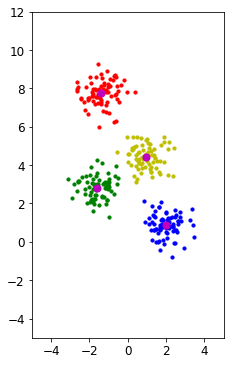

Counter({1.0: 75, 3.0: 75, 0.0: 75, 2.0: 75})


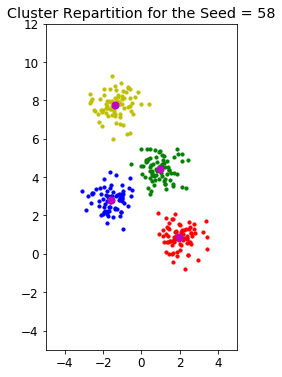

Counter({0.0: 75, 1.0: 75, 3.0: 75, 2.0: 75})


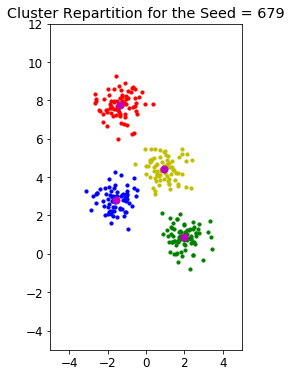

Counter({1.0: 75, 0.0: 75, 2.0: 75, 3.0: 75})


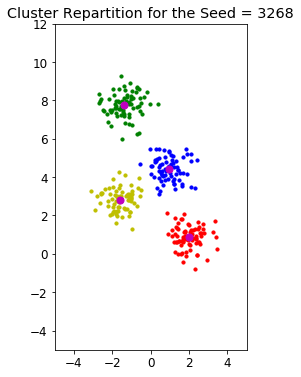

Counter({0.0: 75, 2.0: 75, 1.0: 75, 3.0: 75})


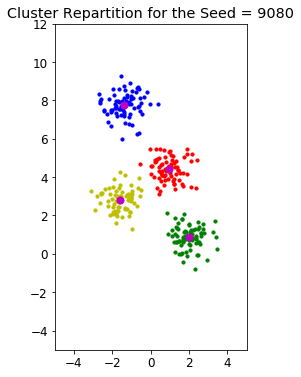

{None: 222.89386306068852, 58: 222.89386306068852, 679: 222.89386306068852, 3268: 222.89386306068852, 9080: 222.89386306068852}


,seed,heterogeneity
0,nan,222.894
1,58,222.894
2,679,222.894
3,3268,222.894
4,9080,222.894


In [130]:
import pandas as pd

#List of the seeds we choose to test 
seeds = [None , 58 , 679 , 3268, 9080]
heterogeneities = []

#For each seed, running kmeans and plotting the result
for seed in seeds:

    k = 4
    
    #Computing the kmeans with heterogeneity
    centroids , centroid_history , cluster_assignment , heterogeneity = kmeans_heterogeneity(X, k, 100, seed)
    print(collections.Counter(cluster_assignment))
    #List of heterogeneity
    heterogeneities.append(heterogeneity) 
    
    #Plotting the different clusters
    plt.figure()
    if (seed!= None):
        plt.title('Cluster Repartition for the Seed = '+str(seed))
        
    #List of the color of our clusters
    color = ['g' , 'r' , 'b' , 'y'  ]

    
    for j in range(len(centroids)):
        list_index = np.argwhere(cluster_assignment==j)
        cluster = np.zeros((len(list_index),2))
        for p in range(len(list_index)):
            cluster[p] = X[list_index[p][0]]

        plt.scatter(cluster[: , 0] , cluster[: , 1] , s=10 , color = color[j])


    plt.scatter(centroids[: , 0] , centroids[: , 1] , s=50 , color = 'm' )  
    centroid_history=np.array(centroid_history)

    plt.ylim(-5, 12)
    plt.xlim(-5, 5)
    plt.gca().set_aspect('equal')
    plt.show()


#Table with the seed value on the first column and its corresponding homogeneity in the second column
ar = np.array(heterogeneities)
df = pd.DataFrame({"seed":seeds, "heterogeneity": ar } )
df.style


#DICTIONNARY DATA
dict={}
for i in range (len(seeds)):
    dict[seeds[i]]= ar[i]
    
print(dict)


#SHOWING The panda data frame
ar = np.array(heterogeneities)
df = pd.DataFrame({"seed":seeds, "heterogeneity": ar } )
df.style


As we can see heterogeneity isn't the same for all the different initialisation. Indeed, heterogeneity gives us an indication about the precision of our clustering algorithm, the less the heterogeneity, the more our clusters are precise. Here we can see that the initialisation is an important factor because the convergence depends from it. The 'naive' implementation, ie use randomness appears to be not efficient for all the cases and so reduce our algorithm's accuracy. We have interest of findig a good initialisation.

# A technique for a smart centroid initialization: $k$-means++

One effective way to produce good initial centroids to feed to $k$-means is to proceed as follows: instead of randomly generating initial centroids, we will try to spread them out in our $d$-dimensional space, such that they are not "too close" to eachother. If you are interested in the details of this technique, you should refer to the link to the original research paper below: in summary, the $k$-means++ technique allows to improve the quality of the local optima in which $k$-means settles, and to reduce the average runtime of the algorithm.

k-means++: the advantages of careful seeding, by David Arthur and Sergei Vassilvitskii (Stanford University) https://dl.acm.org/citation.cfm?id=1283494

A simplified workflow of the $k$-means++ approach is as follows:


* Choose a data point at random from the dataset, this serves as the first centroid
* Compute the squared euclidean distance of all other data points to the randomly chosen first centroid
* To generate the next centroid, each data point is chosen with the probability (weight) of its squared distance to the chosen center in the current round, divided by the the total squared distance (this is just a normalization to make sure the probability adds up to 1). In other words, a new centroid should be as far as possible from the other centroids
* Next, recompute the probability (weight) of each data point as the minimum of the distance between it and all the centers that are already generated (e.g. for the second iteration, compare the data point's distance between the first and second center and choose the smaller one)
* Repeat step 3 and 4 until we have $k$ initial centroids to feed to the $k$-means algorithm


<div class="alert alert-block alert-info">
<strong>Question 6.</strong> Modify your own version of k-means, to introduce the smart initialization technique described above. Don't forget to keep track of heterogeneity as well! The whole point is to measure if k-means++ really improves on this metric.

<br>
<br>

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute the initial clusters according to k-means++</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [8]:
#Function to create the initialize the centroid list
def init(X , k):
    #First center is taken randomly
    first_center = X[np.random.randint(len(X) , size=1)][0]
    centers_list = [first_center]
    #Loop to find the k-1 other initial centroids
    for counter in range(1,k):
        
        weights = np.zeros(len(X))
        total_weight = 0
        
        #Computing the list of the distance to ponderate probability  on it with np.random.choice
        for i in range(len(X)):
            weights_i = []
            for center in centers_list:
                weights_i.append(np.linalg.norm(X[i]-center))
            weight_i = np.min(np.array(weights_i))
            weights[i] = weight_i
            total_weight += weight_i
        weights = weights/total_weight
        next_center = X[np.random.choice(len(X) , 1 , p = weights)]
        centers_list.append(next_center[0])  
    
    return(centers_list)
            
def kmeans_plusplus(X, k, maxiter , seed = None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """
    
    #Initializing the centroid list with init function
    if (seed != None):
        np.random.seed(seed)

    centroids = init(X , k)
    
    
    centroid_history = []
    centroid_history.append(centroids)
    distance_matrix = np.zeros((len(X) , k))
    cluster_assignment = np.zeros(len(X))
    print (centroids)
    
    for itr in range(maxiter):
        
        #Computing the distance matrix  
        for i in range(len(X)):
            for j in range(k):
                distance_matrix[i][j] = np.linalg.norm(X[i]-centroids[j])
                
                
        #Assigning each point to a cluster ( in cluster assignment the index 
        #correspond to the index of X and the value to the clusters assigned to it)
        for i in range(len(X)):
            cluster_assignment[i] = int(np.argmin(distance_matrix[i]))
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = []
        for j in range(k):
            list_index = np.argwhere(cluster_assignment==j)
            sum = 0
            for u in range(len(list_index)):
                sum += X[list_index[u][0]]
            centroid = sum/len(list_index)
            new_centroids.append(centroid)
        
        # STOP CONDITION
        if (np.array_equal(centroids,new_centroids)):
            break
            
        centroids = new_centroids 
        centroid_history.append(centroids)
    
    #compute heterogeneity
    heterogeneity = 0
    for i in range(len(cluster_assignment)):
        j = int(cluster_assignment[i])
        heterogeneity += distance_matrix[i][j]
        
    return np.array(centroids) , np.array(centroid_history) , cluster_assignment , heterogeneity

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Similarly to question 5, using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.
<br>
<br>


Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

<br>

One additional question to answer is the following: print the average heterogeneity for the baseline k-means algorithm, and the average heterogeneity when using the k-means++ initialization. Compare and comment with your own words.
</div>

[array([-2.59201821,  8.07635945]), array([-1.0669061 ,  3.13165795]), array([ 1.68353782,  4.19583243]), array([ 1.75644805,  2.05538289])]
Counter({3.0: 75, 0.0: 75, 2.0: 75, 1.0: 75})


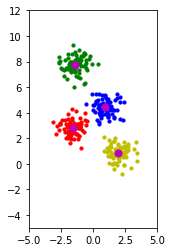

[array([ 1.8155981 ,  1.11969719]), array([-1.68568257,  7.95339446]), array([ 0.91433877,  4.55014643]), array([ 3.22881491,  1.13171965])]
Counter({2.0: 149, 1.0: 75, 0.0: 45, 3.0: 31})


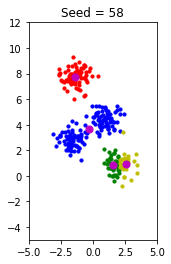

[array([ 1.71444449,  5.02521524]), array([-2.2569867,  7.3020772]), array([ 1.98436909,  0.48955674]), array([-0.58808517,  8.6142732 ])]
Counter({0.0: 149, 2.0: 76, 1.0: 43, 3.0: 32})


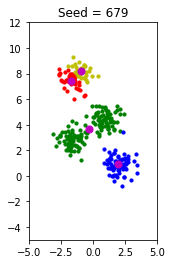

[array([-0.59044767,  7.69493053]), array([ 1.39263752,  0.92896271]), array([ 0.52941719,  3.8079242 ]), array([ 2.03169783,  0.19680756])]
Counter({2.0: 148, 0.0: 75, 1.0: 41, 3.0: 36})


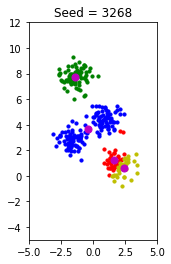

[array([-2.5457675 ,  3.15025055]), array([ 2.60137487,  1.08799459]), array([-1.73163168,  7.16447286]), array([-1.0669061 ,  3.13165795])]
Counter({1.0: 75, 2.0: 75, 3.0: 75, 0.0: 75})


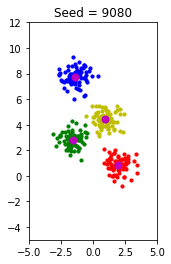

NameError: name 'ar' is not defined

In [9]:
seeds = [None , 58 , 679 , 3268, 9080]
heterogeneities = []
#PLOTTING FOR THE DIFFERENT SEEDS
for seed in seeds:

    k = 4

    centroids , centroid_history , cluster_assignment , heterogeneity = kmeans_plusplus(X, k, 100, seed)
    print(collections.Counter(cluster_assignment))
    heterogeneities.append(heterogeneity)   
    plt.figure()
    if (seed!= None):
        plt.title('Seed = '+str(seed))
    color = ['g' , 'r' , 'b' , 'y'  ]

    for j in range(len(centroids)):
        list_index = np.argwhere(cluster_assignment==j)
        cluster = np.zeros((len(list_index),2))
        for p in range(len(list_index)):
            cluster[p] = X[list_index[p][0]]

        plt.scatter(cluster[: , 0] , cluster[: , 1] , s=10 , color = color[j])
    
    #Plotting the centroids
    plt.scatter(centroids[: , 0] , centroids[: , 1] , s=50 , color = 'm' ) 
    
        
    
    plt.ylim(-5, 12)
    plt.xlim(-5, 5)
    plt.gca().set_aspect('equal')
    plt.show()
    
#DICTIONNARY DATA
dict={}
for i in range (len(seeds)):
    dict[seeds[i]]= ar[i]
    
print(dict)

#Table with seed and heterogeneity corresponding
ar = np.array(heterogeneities)
df = pd.DataFrame({"seed":seeds, "heterogeneity": ar } )
df.style

In [141]:
X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)

heterogeneities_plus = []
heterogeneities_naive = []
k=4
#PLOTTING FOR THE DIFFERENT SEEDS
for i in range(100):

    __, _, _ , heterogeneity1 = kmeans_plusplus(X, k, 100, None)
    
    heterogeneities_plus.append(heterogeneity1)   
    __, _, _ , heterogeneity2 = kmeans_heterogeneity(X, k, 100,None)

    heterogeneities_naive.append(heterogeneity2) 

    

 #Table with heterogeneity corresponding

df = pd.DataFrame({"heterogeneity ++": heterogeneities_plus, "heterogeneity naive" : heterogeneities_naive} )
print("The heterogenity mean with K++ is: ", df["heterogeneity ++"].mean())
print("The heterogenity mean with KNaive is: ", df["heterogeneity naive"].mean())
df.style

The heterogenity mean with K++ is:  246.813855883
The heterogenity mean with KNaive is:  255.305057944


,heterogeneity ++,heterogeneity naive
0,341.249,222.894
1,222.894,222.894
2,222.894,222.894
3,222.894,222.894
4,222.894,222.894
5,222.894,341.249
6,222.894,222.894
7,222.894,222.894
8,222.894,222.894
9,222.894,341.249


As we expect the Kmean++ reduces the heterogeneity in average compared to the naive implementation. This is quite normal is we have more chance to choose point that are far from each other so not in the same real cluster and so the algorithm perfoms better. However this is not perfect all the time because we ponderate the probability.

***

# Determining the value of k: a simple and visual approach, called the Elbow method

Another problem of $k$-means is that we have to specify the number of clusters $k$ before running the algorithm, which we often don't know a priori. 
There are many different heuristics for choosing a suitable value for $k$, the simplest one being the **Elbow method**. Essentially, the idea is to run the $k$-means algorithm using different values of $k$ and plot the corresponding heterogeneity. This measure will decrease as the number of clusters increases, because each cluster will be smaller and tighter. 
By visual inspection of the plot heterogeneity vs. $k$, we will (hopefully!) see that the curve flattens out at some value of $k$: this is what we call an "elbow", and we'll select the value of $k$ corresponding to the "elbow" position.


<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Using the k-means algorithm you implemented, including the smart initialization technique, collect into an array the value of heterogeneity as a function of the number of clusters k, where k is to be selected in the range [2,10].
<br>
<br>


Your output cell should contain:

<ul>
    <li>The plot of heterogeneity vs. k</li>
    <li>A discussion on your visual inspection of the curve, together with a justification for an appropriate choice of the value k</li>
</ul>
</div>

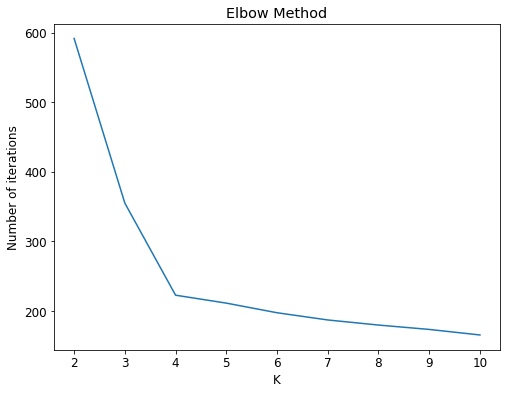

In [134]:
def elbowMethod():
    #List of heterogenity for each k
    heterogeneity_list=[]
    for k in range(2,11):
        _,_,_, heterogeneity = kmeans_plusplus(X, k, 100, seed)
        heterogeneity_list.append(heterogeneity)
    #Plotting the heterogenity vs K
    plt.plot([k for k in range(2,11)], heterogeneity_list)
    plt.xlabel('K')
    plt.ylabel('Number of iterations')
    plt.title('Elbow Method')
    
elbowMethod()



***

# Distributed $k$-means with PySpark

We're now ready to work on a distributed implmentation of the $k$-means algorithm, using the PySpark API.

By now, you should be rather familiar with the $k$-means algorithm, which means we can focus on its parallel and distributed design.

## Distributed algorithm pseudo code

The basic idea of distributed $k$-means is as follows: data points to be clustered should be stored as a distributed dataset, namely a RDD. As in the Notebook on distributed SGD, we will take a shortcut and avoid using HDFS RDDs: rather, we'll use sklearn to generate the data points, similary to the serial version of the algorithms, then use the ```parallelize()``` method to create an RDD, and determine the number of partitions.

We also need to manipulate the centroids array: indeed, all machines should hold a copy of the centroid vector, such that they can proceed independently and in parallel in the first phase of the $k$-means algorithm, that is the **assignment step**. Specifically, every worker has a set of data points, and it will use a copy of the centroid vector to compute cluster assignement: we compute the distance between each data point and each centroid, to assign data points to their closest centroid.

Once the assignement step is done, we need to recompute new centroids based on the assignement, that is, we execute the **update step**. Clearly, we will need to **shuffle** data over the network such that we will have, for each current centroid, the list of all data points that have been assigned to it. If you think about it, this problem should be familiar!! This is very similar to what we do in the Word Count example. As such, you will need to make sure the output of the update step is cast to a ```<key, value>``` type, where the key corresponds to a centroid identifier, and the value contains the list of data points associated to that centroid. The framework will take care of the distributed group by operation, and organize data according to the semantic of our algorithm.

**NOTE:** since we will (potentially) work on large dataset sizes, we don't want our algorithm to return the final assignement after convergence, for otherwise we would need to collect a large amount of data in the driver machine, which has a finite and somehow limited amount of RAM.

The pseudo code of the algorithm you need to implement is as follows:

```python
datapoints = # Use sklearn, as usual, and work on blobs
centroids = # Random initialization

for itr in range(maxiter): # This for loop is executed by the driver
    bcCentroids = sc.broadcast(centroids) # Use broadcast variables
    
    closest = datapoints.mapPartition(assignement_step) # This should happen in parallel
    
    centroids = closest.reduceByKey(update_step_sum). \ # This should happen in parallel
        map(update_step_mean). \ # This should happen in parallel
        collect() # Here we collect new centroids in the driver
```

As you can see from the pseudo code, you need to figure out how to implement the ```assignement_step``` function and the update_step function. For the latter, the pseudo code gives you a big hint! Remember what we discussed in class about computing the mean!

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Implement the distributed version of the k-means algorithm, following the guidelines in the pseudo code.
<br>
<br>

Your output cell should contain:

<ul>
    <li>The value of the centroids once the algorithm converges</li>
    <li>The total runtime of the distributed algorithm, in seconds</li>
    <li>A visualization of the data points and the computed centroids</li>
</ul>

</div>

It takes 2.6261589527130127 seconds to execute


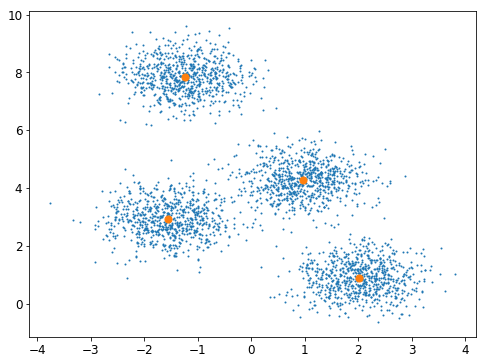

In [142]:
# Use sklearn, as usual, and work on blobs
import time as tm
datapoints,_  = make_blobs(n_samples = 3000, centers = 4,
                  random_state = 0, cluster_std = 0.6)


                             

def distributed_kmeans(datapoints, partitionNumber, seed=None):
    
    #Defining the functions we will need in our map,reduce implementation
    def assignement_step(data,k=4):
        
        #For each point we find the closest centroid and assigning the point to the corresponding cluster
        for datapoint in data:
            distances=np.zeros(k)
            for j in range(k):
                distances[j] = np.linalg.norm(datapoint-bcCentroids.value[j])
            for i in range(k):
                cluster_assignment = int(np.argmin(distances))
            yield (cluster_assignment , [datapoint,1])
            # cluster_assignment is the key corresponding to the cluster , the value is [datapoint, 1], the 1 is necessary to have a counter for each cluster.
  
        
    def update_step_mean(sum):
        return(sum[1][0]/sum[1][1])
        
    
    if (seed != None):
        np.random.seed(seed)
    #Parallelizing the data
    data= sc.parallelize(datapoints,partitionNumber)
    
    #Initializing the centroids randomly
    centroids = X[np.random.choice(X.shape[0], k, replace=False), :]
    
    # This for loop is executed by the driver
    for itr in range(100):
        # Use broadcast variables
        bcCentroids = sc.broadcast(centroids)

        # This should happen in parallel
        
        closest = data.mapPartitions(assignement_step)



        # This should happen in parallel
        #Reduce by Key: Sum along each cluster of the vectors belonging to it
        #Computing the mean of each cluster
        #Sum[1][0] is the sum of all vecotr
        #Sum[1][1] is the number of vector
        new_centroids = closest.reduceByKey(lambda freq1, freq2:(freq1[0] + freq2[0], freq1[1] + freq2[1])).map(update_step_mean).collect()


        # STOP CONDITION
        if (np.array_equal(centroids,new_centroids)):
            break
        centroids = np.array(new_centroids)
    return(centroids)





#RUN TIME
t=tm.time()
centroids= distributed_kmeans(datapoints,6)
t=tm.time()-t
#PLOTTING THE DATA AND THE CENTROIDS
plt.scatter(datapoints[:, 0], datapoints[:, 1], s = 1)
plt.scatter(centroids[:,0], centroids[:,1], s=50)






print ('It takes', t, 'seconds to execute')



<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Answer the following questions:
<br>
<br>
<ul>
    <li>How many partitions did you use? Why?</li>
    <li>What is the size of the dataset you generate? Did you cache the dataset? What's the RAM occupation?</li>
    <li>What is the size of the shuffle data over the network? How does it compare to the dataset size?</li>
</ul>
</div>

Text(0,0.5,'Time to execute')

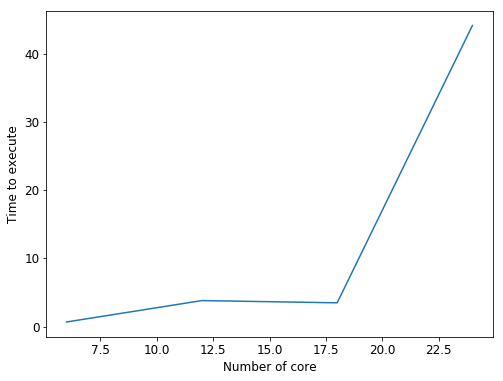

In [136]:
datapoints,y  = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)


core_list=[6,12,18,24]
time_list=[]
for number_of_core in core_list:
    t=tm.time()
    distributed_kmeans(datapoints,number_of_core, 10)
    time_list.append(tm.time()-t)
    
plt.plot(core_list, time_list)
plt.xlabel('Number of core')
plt.ylabel('Time to execute')



1) Generally, when doing partitioning in distributed algorithm we have to choose a number of which is a mutiple of the number of cores. Indeed, most of the time we choose 3 or 4 times the number of core. I tried various number of cores above, (6,12,18,24) and we can see that with 6 cores the algorithm is the fastest. We can explain that by the fact that here our dataset is not larger enough, and the time required to split the data in 18 or 24 partitions and send it across the network to the clusters is too long compared to the time requiered to split the data in 6 partitions and send it to the clusters more the time to run the algorithm. Thus, we choose 6 partitons, because we have six cores and so each one will work on one partitions, because not data is not larger enough to split it into 18 or 24 partitions and gain time. ( We took the precaution to use the same seed so the same initialization of the centroids to compare same computation)



2) The size of dataset is 3000 which represented about 139 KB in memory as you can see in the image below. We don't cache the data as it is already in memory. Indeed in the Spark IU we find that the Disk is not used, everything is already in memory so we don't need to cache (cf picture two)



3) The amount of data shuffled is 10.8 KB for the writing and 5.4KB for the reading. The shuffle is one of the major cost during the Spark Data Frame. The shuffle occurs when data is reorganized between the different machine. This is necessary when a transformation requires information from other partitions, such as the sum of all values in a column. Spark will collect the necessary data from each partition and combine it into a new partition, probably a different executors. This happend during the reducing stage. We want to minimize this step in order to gain in performance. 
Here we manage to do it indeed, our total shuffle data is about 16.4 KB which is less than the 139KB of the initial data. Indeed this is thanks to the reduceByKey operation that merges the values for each key using an associative reduce function. This would be less efficient if we use tje Reduce operation for instance. Indeed the reduce() function takes the two elements as input from the RDD and then produces the output of the same type as that of the input elements so it will need more shuffling to compute.

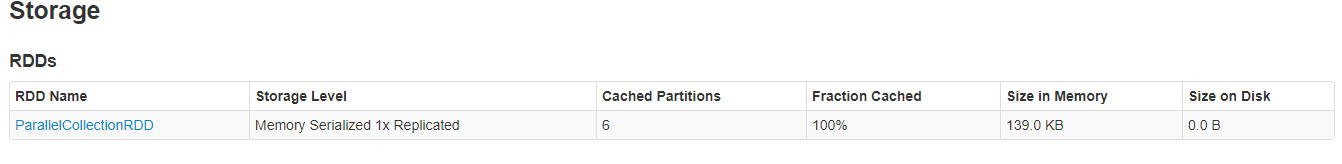

In [137]:
from IPython.display import Image
Image(filename='RDD.PNG')


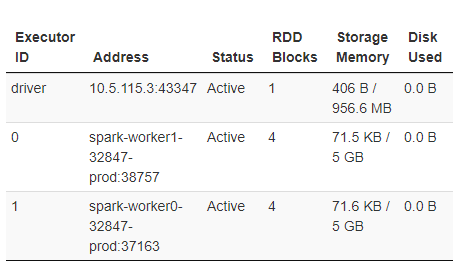

In [138]:
Image(filename='RAM.PNG')

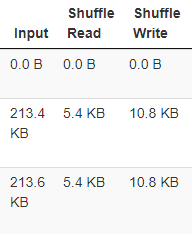

In [139]:
Image(filename='Shuffle.PNG')

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison between serial and distributed implementations.
<br>
<br>
Given the dataset size you chose for your experiments, answer the following questions:
<ul>
    <li>Which is "faster", the serial or distributed implementation of k-means?</li>
    <li>What is a dataset size for which the distributed implementation is clearly faster than the serial one?</li>
    <li>What would be different in your code, should the input dataset reside on disk? Clearly, the input RDD would be reading from HDFS. Any other differences with respect to partitions?</li>
</ul>
</div>

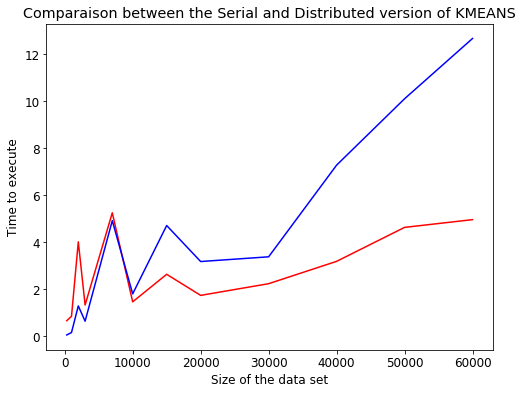

In [140]:
#List containing the size of the data we will use
size_list=[300,1000,2000, 3000, 7000,10000, 15000, 20000, 30000,40000,50000,60000]

#List that will contain in its first column the time to compute the distributed algorithm and in the second column 
#to compute the Serial Implementation
times=[]


#Loop that compute the time to run the distributed and serial implementations
for i in size_list:
    
    #Creating the data of the size precised
    X,y = make_blobs(n_samples = i, centers = 4,
                      random_state = 0, cluster_std = 0.6)
    
    #Computing the time to run the distributed algorithm
    t_distributed=tm.time()
    distributed_kmeans(X,6,10)
    t_distributed=tm.time()-t_distributed

    #Computing the time to run the Serial Algorithm
    t_serial=tm.time()
    kmeans(X,4,100,10)
    t_serial=tm.time()-t_serial

    times.append([t_distributed,t_serial])

times=np.array(times)
plt.title('Comparaison between the Serial and Distributed version of KMEANS')
plt.xlabel('Size of the data set')
plt.ylabel('Time to execute')
plt.plot([i for i in size_list], times[:,0] , 'r')  #Distributed in red
plt.plot([i for i in size_list], times[:,1], 'b' )  #Serial in Blue

1) If we choose the size of 300 the serial algorithm is faster than the distributed part. Indeed, the time to distribute and send the data across the network in the distributed algorithm is not negligeable with respect to the time to compute the algorithm. So with a small size for the dataset you should use the serial implementation which is faster                     
2) To determine when the distributed algorithm is for efficient, we compute the both version of Kmeans and compute the computation time for each. We do this for various size of data, and for the same seed in order to have the same initalization of centroids so the same computation to do. We plot the result as you can seed. We find that from 10 000 points in our dataset, the distributed version is faster than the serial one. This point of 10000 points correspond to the point when the operation of distributed the data across the network to the clusters and then compute in the different machines come more efficient than just computing in one machine. Indeed, the distributed algorithm is interesting for 'BIG DATA' applications and not for a few thousands of point.                               
3) If the input RDD is read from HDFS, or data will be split in the different machines in different block before we splitting it with the partition function. Indeed, with an HDFS file partitioned in the different machines, the Driver Program will ask to each Worker Node the adresses of the place where the data is stored and then schedule them the work they have to do. With HDFS FrameWork it tries to execute the task closer to data in order to avoid data transfers. So there is no need to parallelize and to ship the data to the worker machine as it is already done with HDFS. Thus, the first parallezitions won't be necessary anymore and less data will be shuffle along the clusters during the first step of the algorithm.